In [1]:
import json
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
class TrInfo:
    "simple class to contain dCache billing transfer info"
    def __init__( self, enddate, fname, transfertime, transfersize, filesize ):
        self.endt = datetime.fromisoformat(enddate)
        self.transfert = transfertime/1000
        self.startt = self.endt + timedelta(seconds= -self.transfert)
        self.transfersize = transfersize
        self.filesize = filesize
        self.fname = fname
        self.transferrate = self.transfersize/1e6 / self.transfert # in MB/s
    def __repr__(self):
        return f"TransferInfo: Date {self.startt}, Size {self.transfersize}, Time {self.transfert}, Rate {self.transferrate:.2f}, {self.fname.split('/')[-1]}"


In [3]:
fname = 'billing-2025.11.05_DAOD_PHYSLITE.43637217.json'
#fname = 'billing-2025.10.15_DAOD_PHYSLITE.43637551.json'
#fname = 'billing-2025.10.23_DAOD_PHYSLITE.43637337.json'
#fname='billing-2025.11.10_DAOD_PHYSLITE.43637217.json2'
fname='billing-2025.11.17_DAOD_PHYSLITE.4363_4193.json'

teststartdate = datetime.fromisoformat("2025-11-05T12:30:00.019+01:00")
myda = []
with open('billing/'+fname) as myf:
    for line in myf:
        myd=json.loads(line)
        if (myd['msgType']=='transfer' and
            datetime.fromisoformat(myd['date'])>teststartdate and
            myd['transferTime']>1000 and
            myd['transferSize']>100000) : # only transfers with at least 1 s and >100000 bytes
            mytr = TrInfo( myd['date'], myd['transferPath'], myd['transferTime'], 
                          myd['transferSize'], myd['fileSize'])
            myda.append(mytr)    


In [4]:
fnames = set([x.fname.split('/')[-1] for x in myda])

len(myda),len(fnames)

(44212, 6732)

In [5]:
# total file size
fst = set([(x.fname.split('/')[-1],x.filesize) for x in myda])
len(fst),sum([x[1] for x in fst])/1e9

(6732, 5104.619810534)

In [6]:
sum([x.transfersize for x in myda])/1e9,sum([x.filesize for x in myda])/1e9

(7954.696145437, 33559.6895311)

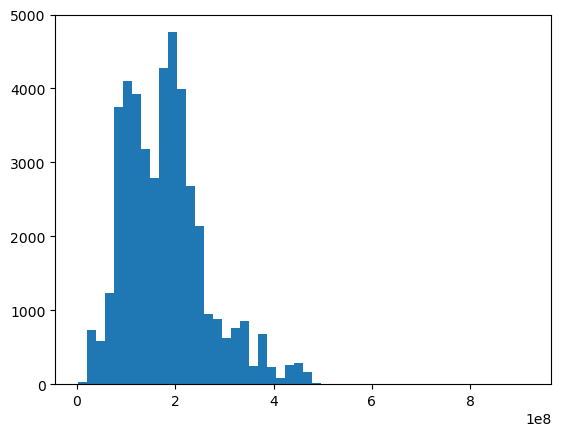

In [7]:
plt.hist([x.transfersize for x in myda],bins=50);

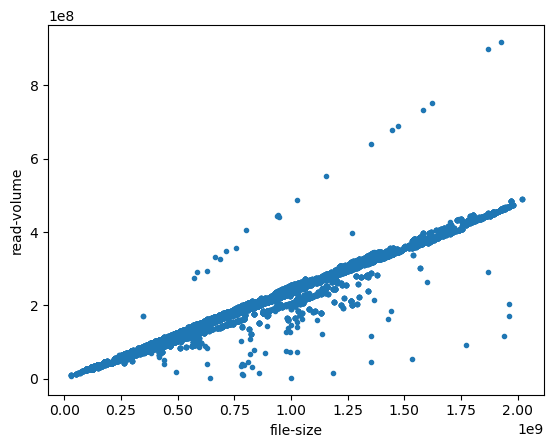

In [8]:
plt.plot([x.filesize for x in myda],[x.transfersize for x in myda],'.');
plt.xlabel('file-size')
plt.ylabel('read-volume');


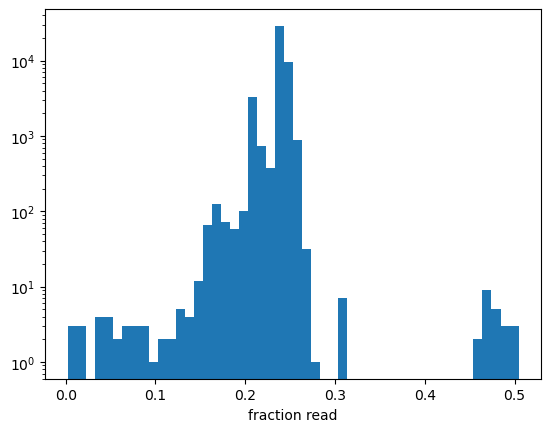

In [9]:
plt.hist([x.transfersize/x.filesize for x in myda],bins=50,log=True);
plt.xlabel('fraction read');

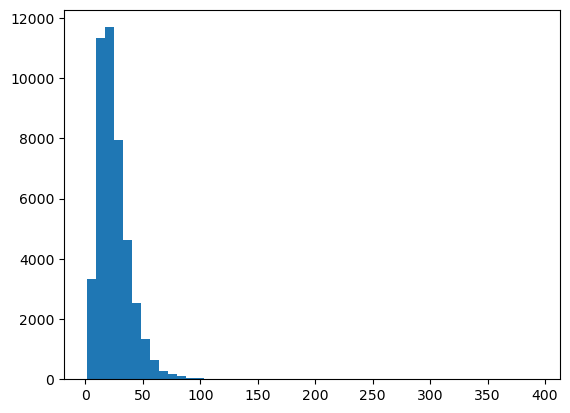

In [10]:
plt.hist([x.transfert for x in myda],bins=50);

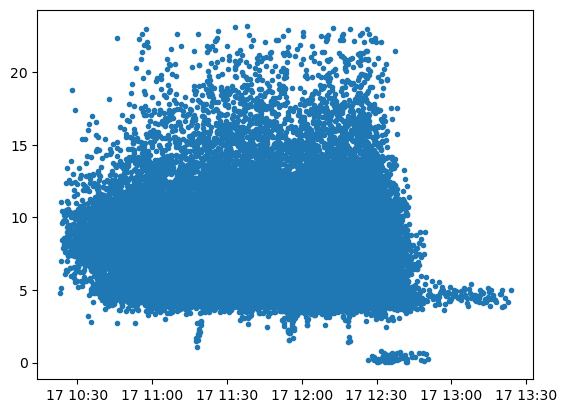

In [11]:
plt.plot([x.startt for x in myda],[x.transferrate for x in myda],'.');

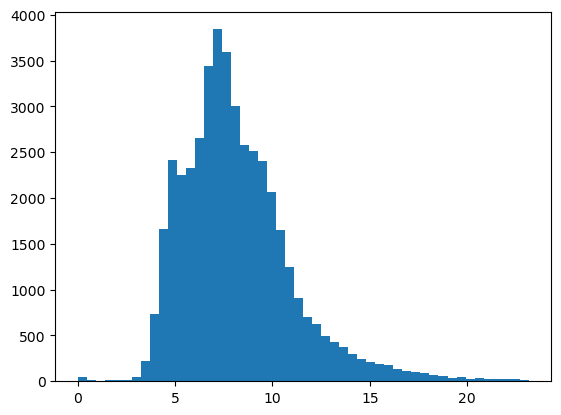

In [12]:

plt.hist([x.transferrate for x in myda],bins=50);

In [13]:
# get earliest transfer start and latest transfer end
st = min(myda,key=lambda x: x.startt).startt
et = max(myda,key=lambda x: x.endt).endt
#print(st,et)
dt  = et-st
minutes_diff = dt.total_seconds() / 60
print(st,et,minutes_diff)

2025-11-17 10:23:04.841000+01:00 2025-11-17 13:24:13.631000+01:00 181.1465


In [14]:
sum([x.transfersize for x in myda])/1e6/dt.total_seconds()

731.8842433644407

In [15]:
nbins = int(minutes_diff+1)
bins = np.arange(nbins+1)
counts = np.zeros(nbins)
trate = np.zeros(nbins)

In [16]:
for myd in myda:
    sb = (myd.startt-st).total_seconds() / 60
    eb = (myd.endt-st).total_seconds() / 60
    sbin = int(sb)
    ebin = int(eb)
    if ebin == sbin:
        wgt = eb-sb
        counts[sbin] += wgt
        trate[sbin] += wgt*myd.transferrate
    else:
        for bin in range(sbin,ebin+1):
            if bin == sbin:
                wgt = (sbin+1) - sb
            elif bin == ebin:
                wgt = eb - ebin
            else:
                wgt = 1.0
            counts[bin] += wgt
            trate[bin] += wgt*myd.transferrate
        
#    counts[sbin:ebin+1] += 1
#    trate[sbin:ebin+1] += myd.transferrate

In [17]:
trate.mean()

728.4520279704212

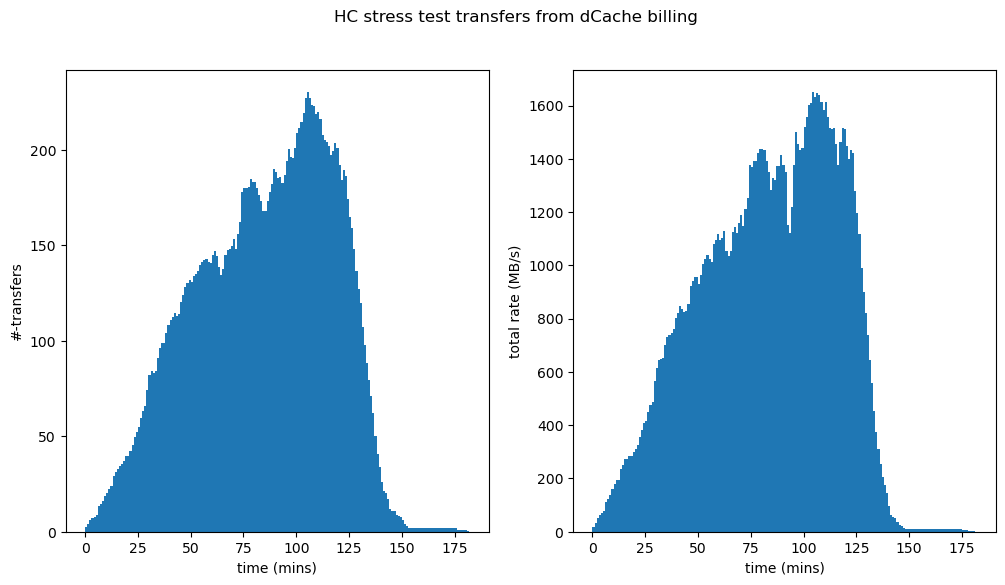

In [18]:
fig = plt.figure(1, figsize=(12,6))
ax1 = fig.add_subplot(121)  # multiple plots: 1x2 , index 1
ax1.hist(bins[:-1],bins,weights=counts)
ax1.set_xlabel('time (mins)')
ax1.set_ylabel('#-transfers');

ax2 = fig.add_subplot(122)  # multiple plots: 1x2 , index 2
ax2.hist(bins[:-1],bins,weights=trate)
ax2.set_xlabel('time (mins)')
ax2.set_ylabel('total rate (MB/s)');
fig.suptitle('HC stress test transfers from dCache billing');
#ax1.xlabel('time (mins)') # x-axis
#ax1.ylabel('#-transfers')# y-axis

#plt.hist(bins[:-1],bins,weights=trate);
fig.savefig('hc_stress_dcbilling.png')

<Axes: >

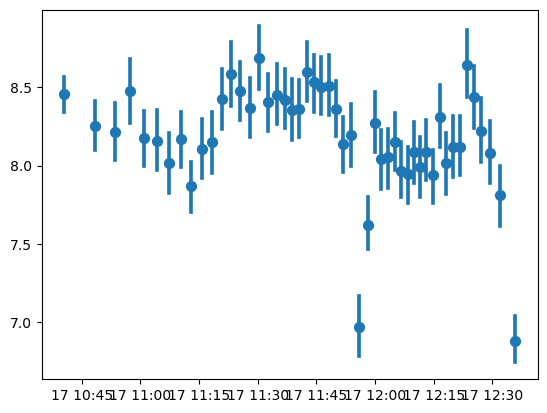

In [19]:
# transfer-rate avg vs time
x=[x.startt for x in myda]
y = [x.transferrate for x in myda]
#plt.plot([x.startt for x in myda],[x.transferrate for x in myda],'.');
sns.regplot(x=x, y=y, x_bins=50, fit_reg=None)
#sns.boxplot(x=x, y=y)


2025-11-17 10:23:04.841000+01:00 2025-11-17 13:24:13.631000+01:00 181.1465


<Axes: >

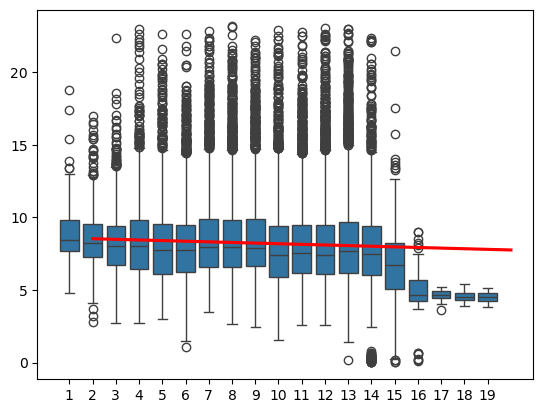

In [20]:
# transfer-rate avg vs time -- with manual digitization 

# get earliest transfer start and latest transfer end
st = min(myda,key=lambda x: x.startt).startt
et = max(myda,key=lambda x: x.endt).endt
#print(st,et)
dt  = et-st
minutes_diff = dt.total_seconds() / 60
print(st,et,minutes_diff)

x=[(x.startt-st).total_seconds() / 60 for x in myda]
y = [x.transferrate for x in myda]

bins = np.linspace(0, minutes_diff, 20)
binc = np.digitize(x, bins)
sns.boxplot(x=binc, y=y);
sns.regplot(x=binc, y=y, scatter=False, color='red')